# Stock forcasting using ARIMA model
### Mushfiqur Rahman [ Mushfiq ]
This project is created for learning purpose.Not recommended for trading. We have used Pyramid Auto Arima which runs multiple models and keep the one with best AIC value. 

In [70]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [71]:
import datetime
import pandas_datareader.data as web

In [72]:
start = datetime.datetime(2015, 1, 3)
end = datetime.date.today()
amzn = web.DataReader("AMZN", 'morningstar', start, end)

In [73]:
dfs = amzn.loc['AMZN']

In [74]:
dfs.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-05,302.19,308.38,300.85,307.02,2774231
2015-01-06,295.29,303.00,292.38,302.20,3519034
2015-01-07,298.42,301.28,295.33,297.54,2640349
2015-01-08,300.46,303.14,296.11,300.59,3088398
2015-01-09,296.93,302.87,296.68,301.50,2592360


In [75]:
dfs.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2018-06-29,1699.80,1723.41,1694.3156,1717.00,4543508
2018-07-02,1713.78,1713.89,1678.0600,1682.70,3185696
2018-07-03,1693.96,1725.00,1692.4800,1723.96,2177276
2018-07-04,1693.96,1693.96,1693.9600,1693.96,0
2018-07-05,1699.73,1710.69,1682.1501,1705.38,2966501


In [76]:
#dfs= dfs.iloc[:-1,:]

In [77]:
dfs.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2018-06-29,1699.80,1723.41,1694.3156,1717.00,4543508
2018-07-02,1713.78,1713.89,1678.0600,1682.70,3185696
2018-07-03,1693.96,1725.00,1692.4800,1723.96,2177276
2018-07-04,1693.96,1693.96,1693.9600,1693.96,0
2018-07-05,1699.73,1710.69,1682.1501,1705.38,2966501


In [78]:
timeseries = dfs['Close']

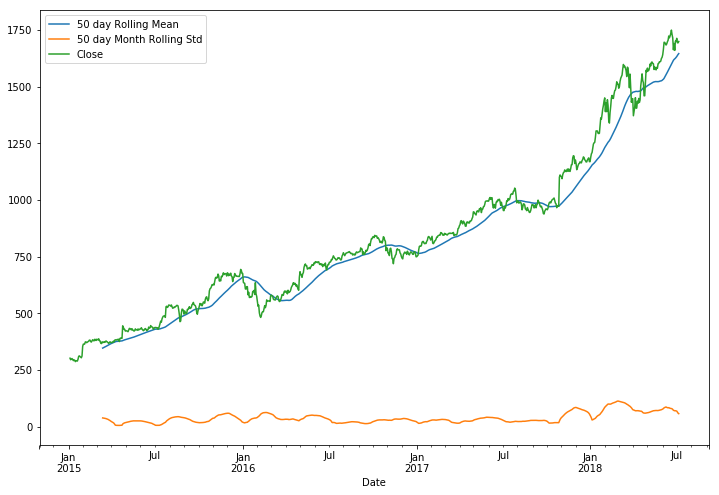

In [79]:
timeseries.rolling(50).mean().plot(label='50 day Rolling Mean', figsize = (12,8))
timeseries.rolling(50).std().plot(label='50 day Month Rolling Std')
timeseries.plot()
plt.legend()

## Decomposition

ETS decomposition allows us to see the individual parts!

<Figure size 432x288 with 0 Axes>

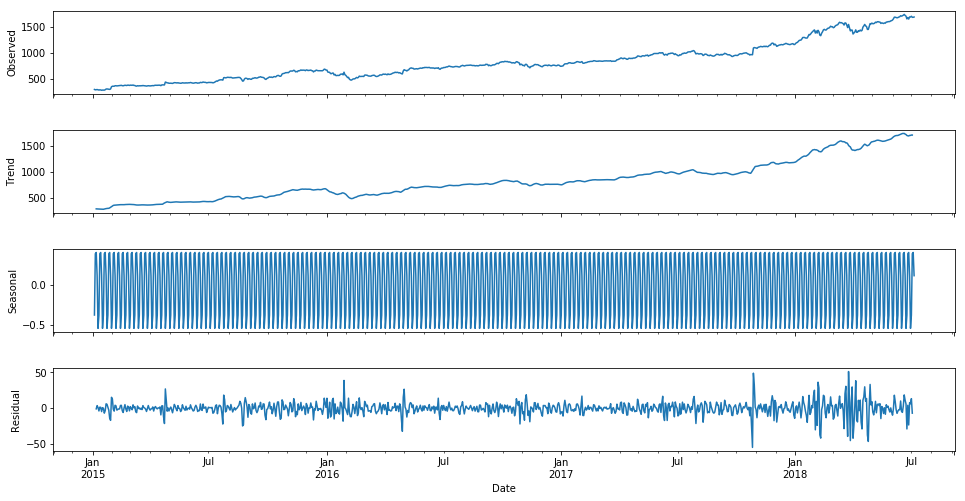

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(timeseries, freq = 5) 
# Check which number for frequecy shows nice seasonality decomposition to be able to observe the seasonality 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Testing for Stationarity

We can use the Augmented [Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) [unit root test](https://en.wikipedia.org/wiki/Unit_root_test).

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, we are trying to whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

Let's run the Augmented Dickey-Fuller test on our data:

In [81]:
from statsmodels.tsa.stattools import adfuller

In [82]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [83]:
adf_check(dfs['Close'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : 0.9159134890177457
p-value : 0.9932945268391242
#Lags Used : 0
Number of Observations Used : 913
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


## Differencing

The first difference of a time series is the series of changes from one period to the next. We can do this easily with pandas. You can continue to take the second difference, third difference, and so on until your data is stationary.

** First Difference **

In [84]:
dfs['Stock First Difference'] = dfs['Close'] - dfs['Close'].shift(1)

In [85]:
adf_check(dfs['Stock First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -18.848848061766503
p-value : 0.0
#Lags Used : 2
Number of Observations Used : 910
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


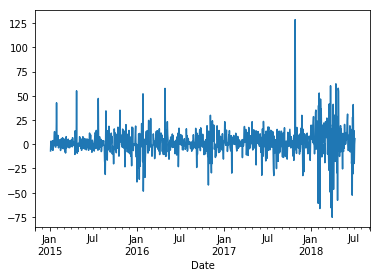

In [86]:
dfs['Stock First Difference'].plot()

** Seasonal Difference **

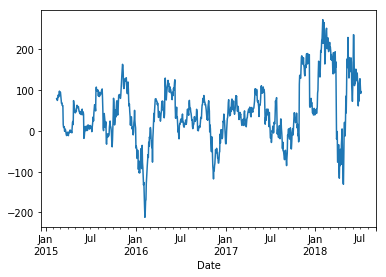

In [87]:
dfs['Seasonal Difference'] = dfs['Close'] - dfs['Close'].shift(30)
dfs['Seasonal Difference'].plot()

In [88]:
# Seasonal Difference by itself was not enough!
adf_check(dfs['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.167336729980049
p-value : 1.024739713221681e-05
#Lags Used : 20
Number of Observations Used : 863
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [89]:
from pyramid.arima import auto_arima

In [90]:
# choose the value of m same as the freq in ETS
stepwise_model = auto_arima(timeseries, start_p=1, start_q=1,
                           max_p=3, max_q=3,m= 5,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 5); AIC=8103.804, BIC=8113.427, Fit time=0.074 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 5); AIC=7772.316, BIC=7791.561, Fit time=0.491 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 5); AIC=7461.191, BIC=7480.436, Fit time=1.486 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 5); AIC=7461.276, BIC=7485.332, Fit time=1.856 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 5); AIC=8105.520, BIC=8119.954, Fit time=0.178 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 5); AIC=7461.500, BIC=7485.556, Fit time=4.131 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 5); AIC=7455.400, BIC=7484.268, Fit time=7.482 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 2, 5); AIC=7

In [91]:
timeseries.tail()

Date
2018-06-29    1699.80
2018-07-02    1713.78
2018-07-03    1693.96
2018-07-04    1693.96
2018-07-05    1699.73
Name: Close, dtype: float64

In [92]:
train = timeseries.loc[:'2018-05-31'] ## creating training data without the last month
test = timeseries.loc['2018-06-01':]  ## Will test the model using the last month data

In [93]:
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 2, 5), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [94]:
future_forecast = stepwise_model.predict(n_periods=len(test))

In [95]:
print(future_forecast)

[1629.21286753 1634.79834031 1634.92064241 1637.15734714 1640.01263417
 1644.25513175 1644.73755174 1650.5254756  1653.62178168 1655.12288164
 1655.28529031 1660.2929751  1661.10434205 1663.46471981 1666.18324444
 1669.96829796 1671.00562847 1676.23064561 1679.26292275 1680.92979093
 1681.54092372 1686.1040739  1687.45722075 1689.91918982 1692.5365425 ]


In [96]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])

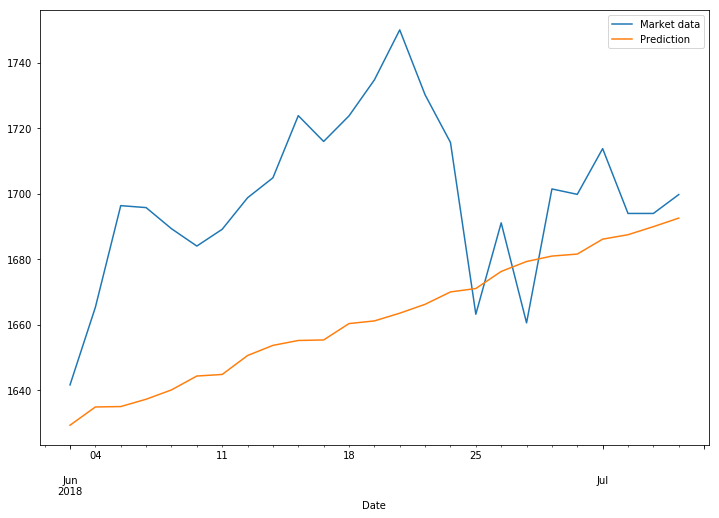

In [97]:
pd.concat([test,future_forecast],axis=1).plot(figsize= (12,8))
plt.legend(('Market data','Prediction' ))

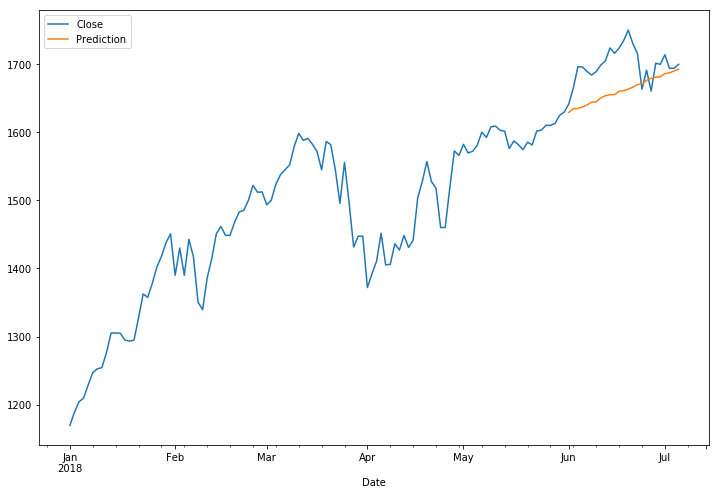

In [98]:
pd.concat([timeseries.loc['2018-01-01':],future_forecast],axis=1).plot(figsize= (12,8))

### Not too bad for our simple model. We could not predict the exterme volality but we got the trend. 

In [99]:
## Today is 5th July. 
## Let's predict the next 30 days  

In [100]:
from pandas.tseries.offsets import DateOffset

In [101]:
future_dates = [dfs.index[-1] + DateOffset(days=x) for x in range(0,30) ]

In [102]:
train2 = dfs['Close'] 

In [103]:
stepwise_model.fit(train2)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 2, 5), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [104]:
forecast = stepwise_model.predict(n_periods=29)

In [105]:
print(forecast)

[1702.33181154 1700.43538463 1706.7473717  1708.17079453 1713.01640619
 1714.44607937 1721.49368254 1722.39618749 1726.10874214 1726.31388893
 1728.81880454 1727.86055463 1733.64208637 1735.32276585 1739.71660701
 1741.27933327 1747.53082388 1748.95558009 1752.48327168 1753.14003583
 1755.57158358 1755.37406047 1760.73284843 1762.62554744 1766.66005155
 1768.33471019 1773.94938197 1775.7996988  1779.18313583]


In [106]:
dfs.drop(['Stock First Difference', 'Seasonal Difference'], axis = 1, inplace=True)

In [107]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=dfs.columns)

In [108]:
forecast = pd.DataFrame(forecast,index = future_dates_df.index,columns=['Forecast'])

In [109]:
future_df = pd.concat([dfs,future_dates_df])

In [110]:
future_df.head()

,Close,High,Low,Open,Volume
2015-01-05,302.19,308.38,300.85,307.02,2774231
2015-01-06,295.29,303.00,292.38,302.20,3519034
2015-01-07,298.42,301.28,295.33,297.54,2640349
2015-01-08,300.46,303.14,296.11,300.59,3088398
2015-01-09,296.93,302.87,296.68,301.50,2592360


In [111]:
future_df.tail()

,Close,High,Low,Open,Volume
2018-07-30,NaN,NaN,NaN,NaN,NaN
2018-07-31,NaN,NaN,NaN,NaN,NaN
2018-08-01,NaN,NaN,NaN,NaN,NaN
2018-08-02,NaN,NaN,NaN,NaN,NaN
2018-08-03,NaN,NaN,NaN,NaN,NaN


In [112]:
len(dfs)

914

In [113]:
future_df['forecast'] = forecast

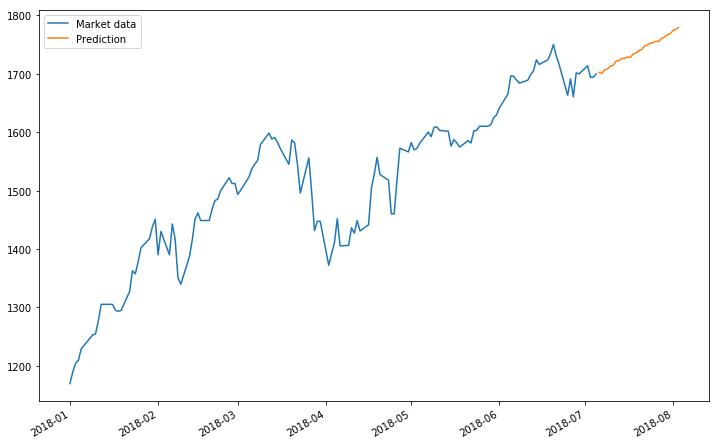

In [114]:
future_df[['Close', 'forecast']].loc['2018-01-01':].plot(figsize=(12, 8)) 
plt.legend(('Market data','Prediction' ))